In [3]:
%load_ext autoreload
%autoreload 2

from bs4 import BeautifulSoup as bs
from lxml import etree
from glob import glob
from tqdm import tqdm
import pandas as pd
import time
import os
import re

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

## Load my existing web scraping methods
from web_scraping import activate_chrome_selenium_latest

#### Test creation of Amazon book urls for web scraping 
In some of my larger projects, I will create a separate set of pytest unit testing scripts. But for small project like this, where I don't expect myself to change my functions as much, I usually just keep some of my testings within my notebooks.

In [4]:
def title_to_url_suffix(book_title: str):
    """ Converting normal title text into url suffix """
    return re.sub(r"[!,*)@#%(&$_?.^'-]", '', book_title).lower().replace(" ", "+")

In [5]:
title_to_url_suffix("Be So Good They Cant Ignore You")

'be+so+good+they+cant+ignore+you'

In [6]:
title_to_url_suffix("Be So Good They Can't Ignore You")

'be+so+good+they+cant+ignore+you'

In [7]:
def title_to_full_url(
    title: str, 
    base_url: str='https://www.amazon.sg/'):
    
    """ Create the actual Amazon url link for web scraping """
    
    query = "s?k=" + title_to_url_suffix(title)
    return base_url + query

In [8]:
title_to_full_url('obstacle is the way')

'https://www.amazon.sg/s?k=obstacle+is+the+way'

In [9]:
title_to_full_url("Be So Good They Cant Ignore You")

'https://www.amazon.sg/s?k=be+so+good+they+cant+ignore+you'

In [10]:
title_to_full_url("Be So Good They Can't Ignore You")

'https://www.amazon.sg/s?k=be+so+good+they+cant+ignore+you'

### Loading Book Lists 
These are the list `"cleaned"` of books that I have noted down. Cleaned, in a sense that I actually had some back and forth checking what were the outputs of my scraper, and going back to my list to modify my book list. So, what is shown here is the final state. This is my master list of book title inputs that I want to scrape from Amazon.

In [11]:
full_book_list = open('book_list_clean.md', 'r').readlines()
full_book_list = [title.replace('\n', '') for title in full_book_list]
len(full_book_list)

232

### The scraping
- I am executing a headless Selenium scraper here using a simple scraper method that I commonly use for my side projects. I purposely added a few time.sleep() to slow down my scraper. I could have use Selenium specific methods to do this, but time.sleep() was just easier to implement.
- In case my scraper breaks due to some unexpected behaviour from Amazon, I decided to break my scraper up into different components, so I could fix the specific chunks of title if they had issues, rather than having to re-run my entire scraper. I iteratively save enough chunk of scraped data as local csv files, which I later read and combine into a single dataframe for further processing / analysis. Not the most production ready set up, but sufficient for a quick POC.
- Also, I could have considered using multi-threading to make my scraper more efficient, but I usually don't go that route because I don't want to get blocked by the site for bot behaviour. In fact, the time.sleep() were included to reduce the chances of Amazon detecting me as a bot and blocking my scraper.
- Used tqdm to trace the progress of my `for`-loops.

In [12]:
# for i in tqdm(range(0,250,5)):
# for i in tqdm(range(0,10,5)):
for i in tqdm(range(100,255,5)):
    try:
        book_lists = full_book_list[i:i+5]
        title_dict = dict()
        browser = activate_chrome_selenium_latest(have_pic=False, is_headless=True)
        
        for title in book_lists:
            url_query = title_to_full_url(title)            
            browser.get(url_query)
            soup = bs(browser.page_source, 'html5lib')

            first_price = soup.find(class_ = 'a-offscreen').text
            final_first_price = float(first_price.replace('S$', ''))
            scrapped_title = soup.find('h2', 'a-size-mini a-spacing-none a-color-base s-line-clamp-4').text.strip()
            title_dict[scrapped_title] = final_first_price
            time.sleep(2)

        ## Saving files locally
        title_prices = pd.DataFrame.from_dict(title_dict, orient='index').reset_index()
        title_prices['title'] = book_lists
        title_prices.columns = ['scraped_title', 'price', 'given_title']
        title_prices[['given_title', 'scraped_title', 'price']].to_csv(f"book_list_{i}_v2.csv", index=False)

        browser.close()
        time.sleep(2)
    except:
        browser.close()
        pass

  0%|                                                                                      | 0/31 [00:00<?, ?it/s]

====== WebDriver manager ======
Current google-chrome version is 104.0.5112
Get LATEST chromedriver version for 104.0.5112 google-chrome
Driver [/Users/cliff/.wdm/drivers/chromedriver/mac64/104.0.5112.79/chromedriver] found in cache
  3%|██▌                                                                           | 1/31 [00:31<15:55, 31.86s/it]

====== WebDriver manager ======
Current google-chrome version is 104.0.5112
Get LATEST chromedriver version for 104.0.5112 google-chrome
Driver [/Users/cliff/.wdm/drivers/chromedriver/mac64/104.0.5112.79/chromedriver] found in cache
  6%|█████                                                                         | 2/31 [01:03<15:27, 31.99s/it]

====== WebDriver manager ======
Current google-chrome version is 104.0.5112
Get LATEST chromedriver version for 104.0.5112 google-chrome
Driver [/Users/cliff/.wdm/drivers/chromedriver/ma

### Check locally saved files

In [12]:
saved_book_list = glob("book_list*_v2.csv")
len(saved_book_list)

48

#### Quick fix
I had a few versions of information that I scraped, and I stuck to loading version 2. Some hotfix was required to load and clean up the data that I want to use. I guess almost everything in a side project can be deemed as a hotfix.

In [13]:
df = pd.DataFrame()
for file in saved_book_list:
    tmp_table = pd.read_csv(file)
    tmp_table['i'] = file.replace('_v2', '').split("_")[-1].split('.')[0]
    df = df.append(tmp_table)
df.reset_index(drop=True, inplace=True)

In [14]:
df.shape

(237, 4)

In [15]:
df.head()

,given_title,scraped_title,price,i
0,Seven steps to train your mind,Seven Steps to Train Your Mind,56.74,125
1,The Obstacle Is The Way,The Obstacle Is the Way: The Timeless Art of Turning Trials into Triumph,23.54,125
2,Growth Hacker Marketing,"Growth Hacker Marketing: A Primer on the Future of PR, Marketing, and Advertising",19.48,125
3,"Trust Me, I’m Lying: Confession of a Media Manipulator","Trust Me, I'm Lying: Confessions of a Media Manipulator",22.89,125
4,"Making Habits, Breaking Habits","Making Habits, Breaking Habits: Why We Do Things, Why We Don't, and How to Make Any Change Stick",27.18,125


### Checking quality of scraping by comparing title input and tile scraped
Web scraping is a pain, and I do it far too often for my liking. Things change and break more often. Here, I wanted to have way to compare the titles that I was looking for against the titles that I captured. Used spacy (my preferred python NLP package) to do a text similarity check. 

**Note**: Not advisable to import packages halfway through your code. This is a no-no in a collaborative setting, as someone else looking at your code may not realise your script needs other packages. For this side project (and for the sake of showing this), I am ok to let my future self scold the past of me.

In [16]:
# !python -m spacy download en

In [17]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

In [18]:
df['title_check'] = [nlp(i).similarity(nlp(j)) for i,j in zip(df.given_title, df.scraped_title)]
to_check = df[df['title_check'] < .7].groupby('i')['title_check'].count().reset_index()
to_check['i'] = to_check['i'].astype(int)
# to_check.sort_values('i').reset_index(drop=True)

There is no quick way to do this other than thinking of a relatively reasonable cut off , and eye-balling the data from there. Human ingenuity still triumphs in many ways.

In [19]:
df['i'] = df['i'].astype(int)
df[df['title_check'] < .7].sort_values('i')

,given_title,scraped_title,price,i,title_check
62,Peddling Prosperity,Peddling Prosperity: Economic Sense and Nonsense in an Age of Diminished Expectations,26.57,0,0.510644
61,hoodwinked: an economic hit man reveals,Hoodwinked: An Economic Hit Man Reveals Why the Global Economy IMPLODED -- and How to Fix It,25.36,0,0.488833
172,Tipping Point,The Tipping Point: How Little Things Can Make a Big Difference,24.74,5,0.457422
173,Blink the power of thinking without thinking,Blink: The Power of Thinking Without Thinking,21.53,5,0.635436
174,Outliers,Outliers: The Story of Success,23.11,5,0.362800
176,The fabric of the cosmos,"The Fabric of the Cosmos: Space, Time, and the Texture of Reality",27.37,5,0.536864
198,the misbehavior of markets,The Misbehavior of Markets: A Fractal View of Financial Turbulence,30.39,10,0.512096
28,The Paradox of Choice,"The Paradox of Choice: Why More Is Less, Revised Edition",19.48,15,0.611815
26,Predictive irrational,"Predictably Irrational, Revised and Expanded Edition: The Hidden Forces That Shape Our Decisions",24.18,15,0.207592
123,Super Crunchers,Super Crunchers: Why Thinking-By-Numbers is the New Way To Be Smart,24.43,20,0.613925


### What the hell, still more issues?
After some intense eyeballing, I had to pick out some titles that didn't match, but because my stakeholder (who is myself) is rushing to have this "product" shipped out, I, the "programmer" decided to just hard code these deletions to make my proof-of-concept look more reasonable in the final analysis. Such things do happen, especially when deadlines are dead. 3 out of 247 is less than 1%. I can accept this level of fudging. 

In [20]:
df = df[df.scraped_title != 'The Cute Book of Kawaii Coloring: Learn Japanese Words by Coloring Cute Things']
df = df[df.scraped_title != 'High-Performance Without Pain: A Companion Workbook for High-Achievers and Those Aspiring To Be']
df = df[df.scraped_title != "Functional Training and Beyond: Building the Ultimate Superfunctional Body and Mind (Building Muscle and Performance, Weight Training, Men's Health)"]

### Finally, what I found out!

In [26]:
# I found some books that were priced about 100 that I felt didn't make sense. 
# For the sake of closing this project, I decided to hard code this condition as well
df = df[df.price <= 100]

In [22]:
print(f"Total books: {df.price.count()} (I removed 6 books)")
print(f"Total book costs: SGD {round(df.price.sum(), 2)}")
print(f"Average book costs: SGD {round(df.price.sum() / df.price.count(), 2)}")

Total books: 230 (I removed 6 books)
Total book costs: SGD 7182.5
Average book costs: SGD 31.23


### Numbers are fine, but hey, we should always add some fancy pantsy graphs, right!? 
Here, I use Plotly, my favourite go-to python visualisation package for non-so-big data sets. Solely because (1) their charts look nice and (2) they allow interactions under certain conditions

In [23]:
import plotly.graph_objects as go

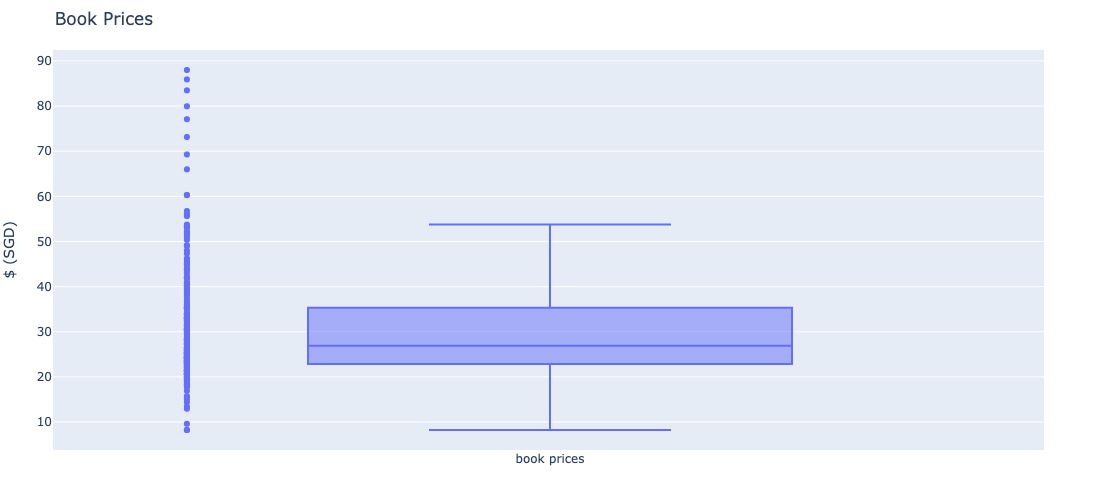

In [31]:
fig = go.Figure()
fig = fig.add_trace(go.Box(
    # Did more data fudging here by manually removing outliers. 
    # WIP - I will take note to fix this. I swear.
    y=df.price,
    name='book prices',
    text=df.scraped_title
))

# Tried to squeeze all my inputs into a single line. 
# This is not known to be a good practice as it is harder to identify the inputs used
fig.update_traces(boxpoints='all', jitter=0)
fig.update_layout(title='Book Prices', yaxis=dict(title='$ (SGD)'), autosize=False, width=800, height=500)
fig.update_layout(margin=dict(l=50, r=50, b=50, t=50, pad=0))
fig

### Getting the graph to share on Medium post
Lastly, do you know you can actually push such interactive graphs into some cloud service (called DataPane), and have the embed the graph into your Medium post? 

In [33]:
import datapane as dp

dp.Report(
    dp.Plot(fig)
).upload(name="Book Price Analysis")

Uploading report and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a single report? More info <a href='https://docs.datapane.com/reports/blocks/layout-pages-and-selects' target='_blank'>here</a>

Report successfully uploaded. View and share your report <a href='https://datapane.com/reports/J35Olak/book-price-analysis/' target='_blank'>here</a>, or edit your report <a href='https://datapane.com/reports/J35Olak/book-price-analysis/edit/' target='_blank'>here</a>.